This is from a tutorial on face recognition to show case a classifier along with datmo, in order to track our work and make machine learning workflow reproducible and usable. We have built classifiers for facial recognition, with very few images. The accuracy from this tutorial can be improved with more training images. You can also increase the number of classes or faces. 


This approach can be categorized into following methods,

* Visualizing the images
* Face detection
* Extracting facial encoding to train a classifier
* Using random forest classifier 
* Using KNN classifier

During the process model engineering, we would be using datmo to create versions of work by creating snapshot.

In [7]:
import os
import face_recognition
import pandas as pd
import numpy as np
import PIL
import matplotlib.pyplot as plt
from glob import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
%matplotlib inline
from IPython.display import display, Image
from datmo.logger import Logger
np.random.seed(4)

##### a. Visualizing the images

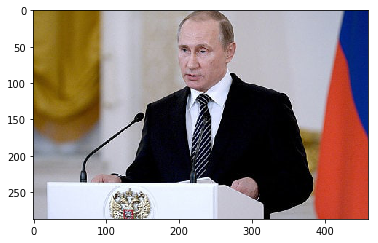

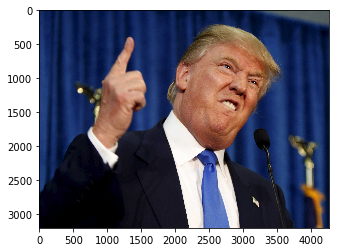

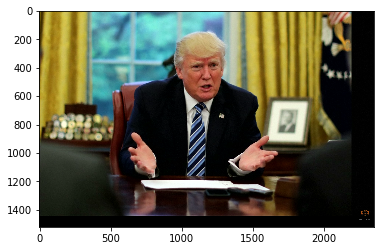

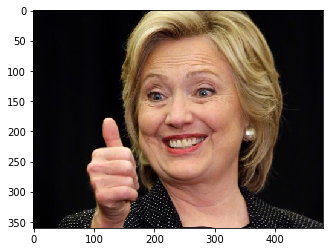

In [8]:
images = [ PIL.Image.open(f) for f in glob('data/test/*') ]

def img2array(im):
    if im.mode != 'RGB':
        im = im.convert(mode='RGB')
    return np.frombuffer(im.tobytes(), dtype='uint8').reshape((im.size[1], im.size[0], 3))

np_images = [ img2array(im) for im in images ]

for img in np_images:
    plt.figure()
    plt.imshow(img)

##### b. Face Detection

Now that we have visualized the images, let's extract face from it. In the following example, we load one of the images in test and get the face locations from it

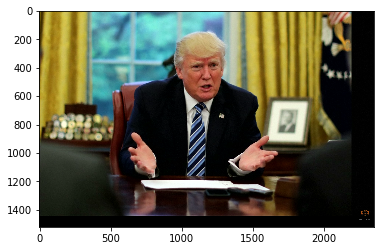

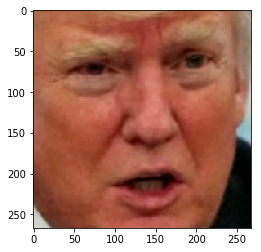

In [9]:
# Load original image

image_path = os.path.join('data', 'test', '1.jpg')

image = face_recognition.load_image_file(image_path)
plt.figure()
plt.imshow(image)

## Facial Detection
face_locations = face_recognition.face_locations(image)
len(face_locations)
for face_location in face_locations:
    # Print the location of each face in this image
    top, right, bottom, left = face_location
    # You can access the actual face itself like this:
    face_image = image[top:bottom, left:right]
    plt.figure()
    plt.imshow(face_image)


Cool! we have now detected the face in image

#### c. Training for facial recognition

In this tutorial, we use `dlib` based `face_recognition` library, to extract the face encodings given an image. With this, we save these facial encodings and train a classifier based on that. 

##### Classes:  `donald_trump`, `putin` and `other`

In [11]:
data = []
target = []
face_names = []
num_faces = len(face_names)
# Training load data
faces_selected = set()
class_names = ['donald_trump','putin','other']
for file_path in glob("data/*/*"):
    class_name = file_path.split('/')[-2]
    if class_name in class_names and class_name != 'test':
        if class_name not in faces_selected:
            faces_selected.add(class_name)
            face_names.append(class_name)
        load_image = face_recognition.load_image_file(file_path)
        list_encoding = face_recognition.face_encodings(load_image)
        if len(list_encoding) > 0:
            face_encoding = list_encoding[0]
            data.append(face_encoding)
            target.append(face_names.index(class_name))

print("Face labels", face_names)

Face labels ['putin', 'other', 'donald_trump']


##### Train and test data split

Let's split out train and test data. Let's then visualize face encodings of these images

In [12]:
face_names = np.array(face_names)
data = np.asarray(data)
dimensions = range(len(face_encoding))
df = pd.DataFrame(data, columns=dimensions)
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .80
df['face'] = pd.Categorical.from_codes(target, face_names)
train, test = df[df['is_train']==True], df[df['is_train']==False]
df.head()

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,is_train,face
0,-0.041071,0.069643,0.110700,-0.074143,-0.131810,0.022707,-0.071340,-0.044077,0.100089,-0.034898,...,0.066698,0.002613,-0.148067,-0.158345,-0.026570,0.011718,0.036830,0.111807,False,putin
1,-0.039352,0.160657,0.050732,-0.042872,-0.146285,-0.015821,-0.113523,0.000278,0.090593,0.025682,...,0.056595,0.002529,-0.174600,-0.121554,-0.036829,-0.036827,-0.010057,0.106484,True,putin
2,-0.099176,0.196138,0.092028,-0.082432,-0.107714,0.021190,-0.048023,-0.077974,0.088324,0.002425,...,0.034498,0.033140,-0.194526,-0.141094,-0.013987,-0.004457,0.013244,0.113035,False,putin
3,-0.075393,0.149579,0.083450,-0.045515,-0.144917,0.055448,-0.061247,-0.037471,0.164672,-0.065107,...,0.031870,0.066698,-0.164819,-0.134698,-0.004607,-0.002677,-0.049746,0.083549,True,putin
4,-0.106312,0.133825,0.064905,-0.070130,-0.137039,0.013353,-0.089225,-0.103699,0.079733,0.008015,...,-0.043928,0.028103,-0.207121,-0.137373,-0.016876,-0.000697,-0.031530,0.098944,True,putin


In [13]:
features = df.columns[:len(face_encoding)]
y_train, _ = pd.factorize(train['face'])
y_test, _ = pd.factorize(test['face'])
X_train, X_test = train[features], test[features]

##### d. Using random forest classifier 

In [16]:
config = { "n_jobs": 6, "n_estimators": 10 , "algorithm": "random forest"} 

# Training a random forest classifier
clf = RandomForestClassifier(n_jobs=config["n_jobs"], n_estimators=10)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=6,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [19]:
import json
import pickle
from sklearn.metrics import accuracy_score

y_pred = np.array(clf.predict(X_test))
preds = face_names[y_pred]
cross_validation = pd.crosstab(test['face'], preds, rownames=['actual'], colnames=['preds'])
print(cross_validation)

with open('config.json', 'w') as outfile:
    json.dump(config, outfile)
pickle.dump(clf, open('model.dat', 'wb'))

# SAVE RESULTS
stats = {'accuracy': accuracy_score(y_test, y_pred)}
with open('stats.json', 'w') as outfile:
    json.dump(stats, outfile)

preds         donald_trump  other  putin
actual                                  
putin                    0      1      4
other                    0      3      0
donald_trump             1      0      0


### Visualizing the model performance over test data

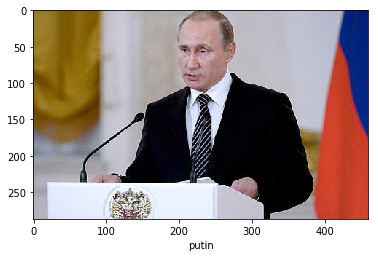

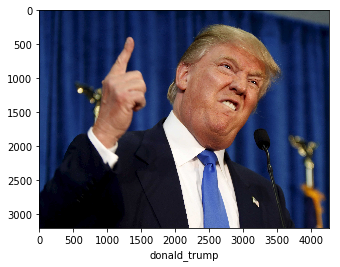

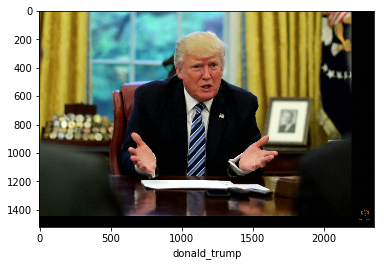

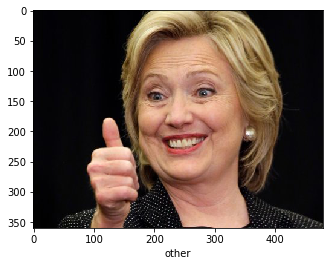

In [20]:
for image_path in glob('data/test/*'):
    load_image = face_recognition.load_image_file(image_path)
    list_encoding = face_recognition.face_encodings(load_image)
    test_pred = face_names[np.array(clf.predict(list_encoding))]
    plt.figure()
    plt.imshow(load_image)
    plt.xlabel(test_pred[0])

#### NOTE: SAVE YOUR JUPYTER NOTEBOOK HERE

Creating a datmo snapshot to save my work, this helps me save my current work before proceeding onto data cleaning.

Run this on your terminal to create a snapshot,

```bash
home:~/datmo-face-recognition$ datmo snapshot create -m "random forest classifier"
Creating a new snapshot
Created snapshot with id: 9095c50d30
```

After running this, you should be able view the created snapshot using the command, `snapshot ls`

```bash
home:~/datmo-face-recognition$ datmo snapshot ls
+-------------+-----------+--------------------+---------------+--------------+-------+
|   id        | created at|      config        |      stats    |    message   | label |
+-------------+-----------+--------------------+---------------+--------------+-------+
| 9095c50d30  | 2018-06-03|   {'n_jobs': 6}    | {'accuracy':  | random forest|  None |
|             | 07:22:07  |                    |  0.9375}      |  classifier  |       |
+-------------+-----------+--------------------+---------------+--------------+-------+
```

#### Using KNN classifier

In [19]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 7).fit(X_train, y_train)
 
# accuracy on X_test
accuracy = knn.score(X_test, y_test)

In [20]:
# Let's save the config and stats information
config = {'n_neightbors': 7}
with open('config.json', 'w') as outfile:
    json.dump(config, outfile)
pickle.dump(knn, open('model.dat', 'wb'))
stats = {'accuracy': accuracy}
with open('stats.json', 'w') as outfile:
    json.dump(stats, outfile)

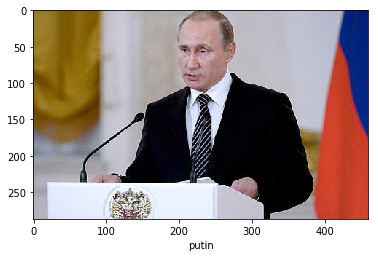

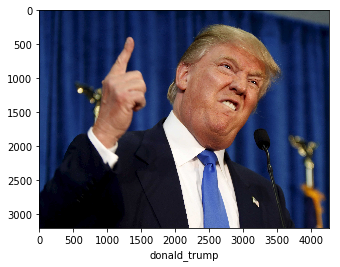

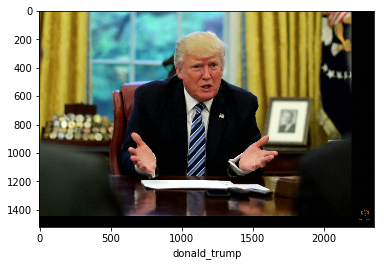

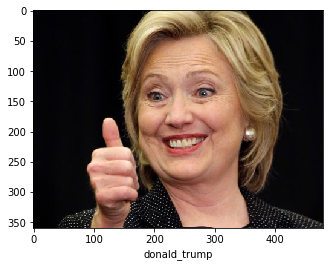

In [21]:
for image_path in glob('data/test/*'):
    load_image = face_recognition.load_image_file(image_path)
    list_encoding = face_recognition.face_encodings(load_image)
    test_pred = face_names[np.array(knn.predict(list_encoding))]
    plt.figure()
    plt.imshow(load_image)
    plt.xlabel(test_pred[0])

#### NOTE: SAVE YOUR JUPYTER NOTEBOOK HERE

Creating a datmo snapshot to save my work, this helps me save my current work before proceeding onto data cleaning.

Run this on your terminal to create a snapshot,

```bash
home:~/datmo-face-recognition$ datmo snapshot create -m "knn classifier"
Creating a new snapshot
Created snapshot with id: 7a3530f742
```

After running this, you should be able view the created snapshot using the command, `snapshot ls`

```bash
home:~/datmo-tutorials/face-recognition$ datmo snapshot ls
+-------------+-----------+--------------------+---------------+--------------+-------+
|   id        | created at|      config        |      stats    |    message   | label |
+-------------+-----------+--------------------+---------------+--------------+-------+
| 7a3530f742  | 2018-06-03| {'n_neightbors': 7}| {'accuracy':  |     knn      |  None |
|             | 07:22:07  |                    |   0.8125}     |  classifier  |       |
+-------------+-----------+--------------------+---------------+--------------+-------+
| 9095c50d30  | 2018-06-03|   {'n_jobs': 6}    | {'accuracy':  | random forest|  None |
|             | 07:22:07  |                    |  0.9375}      |  classifier  |       |
+-------------+-----------+--------------------+---------------+--------------+-------+
```

###### Let's now move to a different snapshot in order to move to a previous files in that version. You can save your Jupyter notebook here and run the code below in a new terminal. You should see your Jupyter notebook change to the previous version.

We perform checkout command in order to achieve it
```
home:~/datmo-face-recognition$ # Run this command: datmo snapshot checkout --id <snapshot-id>
home:~/datmo-face-recognition$ datmo snapshot checkout --id 9095c50d30
```

#### Listing runs and and reruning them
You can list the runs using the command,
```
home:~/datmo-face-recognition$ datmo run ls
```

Now, you can rerun any experiment for a particular run-id from the listed runs.

```
home:~/datmo-face-recognition$ datmo rerun <run-id>
```